# 70.単語ベクトルの和による特徴量

In [2]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary = True)

In [4]:
import pandas as pd
import re, gensim, torch
import numpy as np

In [5]:
def word_feature(text):
    df = pd.read_table(text ,index_col=0)
    X = []
    Y = []
    for category, title in df.iterrows():
        emb = [model[word] for word in title[0].split(' ') if word in model]
        if len(emb) != 0:
            x = sum(emb) / len(emb)
        else:
            x = np.zeros(300)
        X.append(x)
        if category == 'b':
            Y.append(0)
        elif category == 't':
            Y.append(1)
        elif category == 'e':
            Y.append(2)
        else:
            Y.append(3)
    return torch.tensor(X).float(),torch.tensor(Y).float()

In [6]:
train_X,train_Y = word_feature('train.txt')
test_X,test_Y   = word_feature('test.txt')
valid_X,valid_Y = word_feature('valid.txt')

In [7]:
torch.save(train_X, 'train_X.pt')
torch.save(train_Y, 'train_Y.pt')
torch.save(test_X, 'test_X.pt')
torch.save(test_Y, 'test_Y.pt')
torch.save(valid_X, 'valid_X.pt')
torch.save(valid_Y, 'valid_Y.pt')

# 71.単装ニューラルネットワークによる予測

In [8]:
import torch.nn as nn
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.fc = nn.Linear(input_size,output_size,bias=False)
        
    def forward(self,x):
        x = self.fc(x)
        return x

In [9]:
model_ = NeuralNetwork(300,4)    

In [10]:
y = model_(train_X[0])
y = torch.softmax(y,dim = 0)
y

tensor([0.2725, 0.2341, 0.2442, 0.2492], grad_fn=<SoftmaxBackward>)

In [11]:
Y = model_(train_X[:4])
Y = torch.softmax(Y, dim=1)
Y

tensor([[0.2725, 0.2341, 0.2442, 0.2492],
        [0.2395, 0.2573, 0.2417, 0.2615],
        [0.2336, 0.2579, 0.2569, 0.2517],
        [0.2505, 0.2398, 0.2565, 0.2532]], grad_fn=<SoftmaxBackward>)

# 72.損失と勾配の計算

In [12]:
loss_fn = nn.CrossEntropyLoss()

In [13]:
loss = loss_fn(model_(train_X[:1]),train_Y[:1].type(torch.long))
model_.zero_grad()
loss.backward()
print('loss:',loss.item())
print('gradient:',model_.fc.weight.grad)

loss: 1.4097694158554077
gradient: tensor([[ 0.0442,  0.0473, -0.0234,  ..., -0.0365,  0.0214,  0.0134],
        [ 0.0380,  0.0407, -0.0201,  ..., -0.0314,  0.0184,  0.0115],
        [-0.1226, -0.1313,  0.0650,  ...,  0.1013, -0.0593, -0.0371],
        [ 0.0404,  0.0433, -0.0214,  ..., -0.0334,  0.0196,  0.0123]])


In [14]:
loss = loss_fn(model_(train_X[:4]),train_Y[:4].type(torch.long))
model_.zero_grad()
loss.backward()
print('loss:',loss.item())
print('gradient:',model_.fc.weight.grad)

loss: 1.4279836416244507
gradient: tensor([[ 7.5129e-03, -2.6145e-03, -1.5603e-02,  ..., -5.1055e-03,
          1.1626e-02, -4.1431e-03],
        [ 6.5152e-03,  7.2762e-03, -2.6156e-03,  ..., -1.3691e-02,
         -4.4037e-03,  2.9649e-03],
        [-3.7236e-02, -1.6884e-02,  2.6314e-02,  ...,  3.1937e-02,
         -1.1932e-02,  4.7543e-06],
        [ 2.3208e-02,  1.2222e-02, -8.0949e-03,  ..., -1.3141e-02,
          4.7100e-03,  1.1734e-03]])


# 73.確率的勾配降下法による学習

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t
        self.size = len(x)
    
    def __len__(self):
        return self.size
            
    def __getitem__(self, index):
        return [
                self.x[index],
                self.t[index]]

def train_loop(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred,y.type(torch.long))
        
        #back
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.type(torch.long)).type(torch.float).sum().item()
            
    
        
   #     if batch % 100 == 0:
    #        loss, current = loss.item(), batch * len(X)
     #       print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= size
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    
    return 100*correct, train_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.type(torch.long)).item()
            correct += (pred.argmax(1) == y.type(torch.long)).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    return 100*correct, test_loss

In [16]:
from torch.utils.data import DataLoader
traindata = Dataset(train_X,train_Y)
testdata = Dataset(test_X,test_Y)


train_loader = DataLoader(traindata,batch_size=1, shuffle=True)
test_loader = DataLoader(testdata,batch_size=1, shuffle=False)

model = NeuralNetwork(300,4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.01)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1-------------------------------
Accuracy: 78.0%, Avg loss: 0.697478
Test Error: Accuracy: 81.7%, Avg loss: 0.538296
Epoch 2-------------------------------
Accuracy: 83.6%, Avg loss: 0.486347
Test Error: Accuracy: 85.3%, Avg loss: 0.454752
Epoch 3-------------------------------
Accuracy: 85.8%, Avg loss: 0.427370
Test Error: Accuracy: 86.8%, Avg loss: 0.417375
Epoch 4-------------------------------
Accuracy: 87.0%, Avg loss: 0.396131
Test Error: Accuracy: 87.5%, Avg loss: 0.395045
Epoch 5-------------------------------
Accuracy: 87.8%, Avg loss: 0.376552
Test Error: Accuracy: 88.0%, Avg loss: 0.381007
Epoch 6-------------------------------
Accuracy: 88.2%, Avg loss: 0.362656
Test Error: Accuracy: 88.1%, Avg loss: 0.371154
Epoch 7-------------------------------
Accuracy: 88.5%, Avg loss: 0.352168
Test Error: Accuracy: 88.1%, Avg loss: 0.364636
Epoch 8-------------------------------
Accuracy: 88.7%, Avg loss: 0.343920
Test Error: Accuracy: 88.1%, Avg loss: 0.358324
Epoch 9---------

# 74.正解率の計測

In [1]:
def accuracy(dataloader, model):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
       #     print((pred.argmax(1) == y).type(torch.float).item())
            correct += (pred.argmax(1) == y).item()
            
    correct /= size
    return correct

In [2]:
train_accuracy = accuracy(train_loader,model)
test_accuracy = accuracy(test_loader,model)
print(f'train: {train_accuracy:.3f}')
print(f'test : {test_accuracy:.3f}')

NameError: name 'train_loader' is not defined

# 75.損失と正解率のプロット

In [189]:
model = NeuralNetwork(300,4)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

train_res = []
valid_res = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_acc, train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    valid_acc, valid_loss = test_loop(test_loader, model, loss_fn)
   
    train_res.append((train_acc,train_loss))
    valid_res.append((valid_acc,valid_loss))

print("Done!")


Epoch 1-------------------------------
Accuracy: 61.4%, Avg loss: 0.010492
Test Error: Accuracy: 72.7%, Avg loss: 0.010675
Epoch 2-------------------------------
Accuracy: 74.7%, Avg loss: 0.009931
Test Error: Accuracy: 76.2%, Avg loss: 0.010144
Epoch 3-------------------------------
Accuracy: 76.2%, Avg loss: 0.009473
Test Error: Accuracy: 76.7%, Avg loss: 0.009704
Epoch 4-------------------------------
Accuracy: 76.7%, Avg loss: 0.009086
Test Error: Accuracy: 77.1%, Avg loss: 0.009333
Epoch 5-------------------------------
Accuracy: 76.9%, Avg loss: 0.008758
Test Error: Accuracy: 77.3%, Avg loss: 0.009016
Epoch 6-------------------------------
Accuracy: 77.1%, Avg loss: 0.008474
Test Error: Accuracy: 77.3%, Avg loss: 0.008741
Epoch 7-------------------------------
Accuracy: 77.2%, Avg loss: 0.008229
Test Error: Accuracy: 77.4%, Avg loss: 0.008502
Epoch 8-------------------------------
Accuracy: 77.2%, Avg loss: 0.008015
Test Error: Accuracy: 77.4%, Avg loss: 0.008290
Epoch 9---------

[(0.6136619190404797, 0.010491506773224477), (0.7466266866566716, 0.009931388387883799), (0.7619940029985007, 0.009472610096613328), (0.7669602698650675, 0.009085651704932618), (0.7694902548725637, 0.008757874548345848), (0.7708020989505248, 0.008474255681618758), (0.7716454272863568, 0.008228547826431681), (0.7722076461769115, 0.0080150136726907), (0.7723950524737632, 0.007827075541779019), (0.7722076461769115, 0.007659659856396994)]


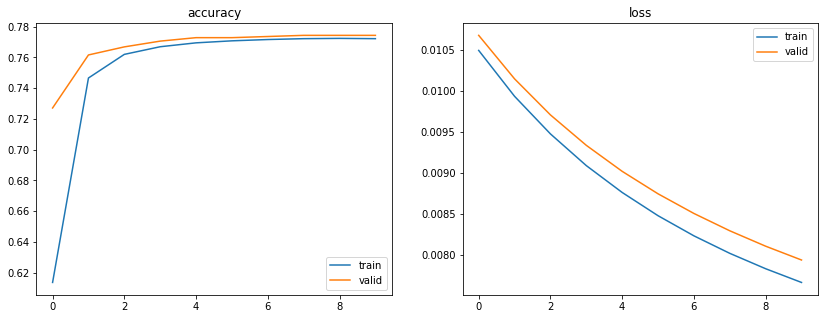

In [193]:
import matplotlib.pyplot as plt

train_acc = [i[0] for i in train_res]
train_loss= [i[1] for i in train_res]
valid_acc = [i[0] for i in valid_res]
valid_loss = [i[1] for i in valid_res]


fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(train_acc, label='train')
ax[0].plot(valid_acc, label='valid')
ax[1].plot(train_loss, label='train')
ax[1].plot(valid_loss, label='valid')
ax[0].set_title("accuracy")
ax[1].set_title("loss")
ax[0].legend()
ax[1].legend()

# 76.チェックポイント

In [134]:
model = NeuralNetwork(300,4)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)


train_res = []
valid_res = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
    torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'checkpoint{t+1}.pt')
print("Done!")

Epoch 1-------------------------------
Accuracy: 78.3%, Avg loss: 0.694679
Test Error: Accuracy: 81.6%, Avg loss: 0.536945
Epoch 2-------------------------------
Accuracy: 83.5%, Avg loss: 0.486416
Test Error: Accuracy: 84.9%, Avg loss: 0.453981
Epoch 3-------------------------------
Accuracy: 85.8%, Avg loss: 0.427310
Test Error: Accuracy: 86.7%, Avg loss: 0.416404
Epoch 4-------------------------------
Accuracy: 87.2%, Avg loss: 0.395879
Test Error: Accuracy: 87.3%, Avg loss: 0.394411
Epoch 5-------------------------------
Accuracy: 87.7%, Avg loss: 0.375916
Test Error: Accuracy: 88.1%, Avg loss: 0.382628
Epoch 6-------------------------------
Accuracy: 88.2%, Avg loss: 0.362454
Test Error: Accuracy: 87.7%, Avg loss: 0.371192
Epoch 7-------------------------------
Accuracy: 88.5%, Avg loss: 0.351943
Test Error: Accuracy: 87.9%, Avg loss: 0.365006
Epoch 8-------------------------------
Accuracy: 88.7%, Avg loss: 0.343858
Test Error: Accuracy: 88.1%, Avg loss: 0.358093
Epoch 9---------

In [194]:
! ls checkpoint*

checkpoint1.pt  checkpoint2.pt  checkpoint4.pt  checkpoint6.pt  checkpoint8.pt
checkpoint10.pt checkpoint3.pt  checkpoint5.pt  checkpoint7.pt  checkpoint9.pt


# 77.ミニバッチ化


In [136]:
from time import time
batchsize = [1,2,4,8,16,32,64,128]

for b in batchsize:
    print(f'batchsize:{b}')
    train_loader = DataLoader(traindata,batch_size=b, shuffle=True)
    test_loader = DataLoader(testdata,batch_size=b, shuffle=False)
    
    model = NeuralNetwork(300,4)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
    
    epochs = 4
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
        test_loop(test_loader, model, loss_fn)
    print(f'{(time()-start):>0.3f}秒\n')
print("Done!")

batchsize:1
Epoch 1-------------------------------
Accuracy: 78.0%, Avg loss: 0.695678
Test Error: Accuracy: 81.5%, Avg loss: 0.539306
Epoch 2-------------------------------
Accuracy: 83.4%, Avg loss: 0.487089
Test Error: Accuracy: 85.1%, Avg loss: 0.455827
Epoch 3-------------------------------
Accuracy: 85.9%, Avg loss: 0.427570
Test Error: Accuracy: 86.9%, Avg loss: 0.417705
Epoch 4-------------------------------
Accuracy: 86.9%, Avg loss: 0.396136
Test Error: Accuracy: 87.6%, Avg loss: 0.395748
13.759秒

batchsize:2
Epoch 1-------------------------------
Accuracy: 77.1%, Avg loss: 0.403340
Test Error: Accuracy: 78.5%, Avg loss: 0.319301
Epoch 2-------------------------------
Accuracy: 79.6%, Avg loss: 0.289928
Test Error: Accuracy: 81.7%, Avg loss: 0.269225
Epoch 3-------------------------------
Accuracy: 82.6%, Avg loss: 0.253335
Test Error: Accuracy: 84.2%, Avg loss: 0.243620
Epoch 4-------------------------------
Accuracy: 84.3%, Avg loss: 0.232160
Test Error: Accuracy: 85.5%, Av

# 78.GPU上での学習

In [196]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    
    model.to(device)
    
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y.type(torch.long))
        
        #back
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.type(torch.long)).type(torch.float).sum().item()
            
    
        

    train_loss /= size
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    
    return 100*correct, train_loss

def test_loop(dataloader, model, loss_fn,device):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    model.to(device)

    with torch.no_grad():
        for (X, y) in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.type(torch.long)).item()
            correct += (pred.argmax(1) == y.type(torch.long)).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error:Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    return 100*correct, test_loss

In [200]:
device = torch.device('')

batchsize = [1,2,4,8,16,32,64,128]

for b in batchsize:
    print(f'batchsize:{b}')
    train_loader = DataLoader(traindata,batch_size=b, shuffle=True)
    test_loader = DataLoader(testdata,batch_size=b, shuffle=False)
    
    model = NeuralNetwork(300,4)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
    
    epochs = 4
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer,device)
        test_loop(test_loader, model, loss_fn, device)
    print(f'{(time()-start):>0.3f}秒\n')
print("Done!")

#  colab

# batchsize:1
# Epoch 1-------------------------------
# Accuracy: 78.0%, Avg loss: 0.694822
# Test Error:Accuracy: 81.9%, Avg loss: 0.540298
# Epoch 2-------------------------------
# Accuracy: 83.5%, Avg loss: 0.486402
# Test Error:Accuracy: 84.8%, Avg loss: 0.455016
# Epoch 3-------------------------------
# Accuracy: 85.6%, Avg loss: 0.427068
# Test Error:Accuracy: 87.0%, Avg loss: 0.417441
# Epoch 4-------------------------------
# Accuracy: 87.0%, Avg loss: 0.395632
# Test Error:Accuracy: 87.1%, Avg loss: 0.395601
# 32.598秒

# batchsize:2
# Epoch 1-------------------------------
# Accuracy: 76.6%, Avg loss: 0.404370
# Test Error:Accuracy: 78.6%, Avg loss: 0.319764
# Epoch 2-------------------------------
# Accuracy: 79.7%, Avg loss: 0.290735
# Test Error:Accuracy: 81.4%, Avg loss: 0.269203
# Epoch 3-------------------------------
# Accuracy: 82.6%, Avg loss: 0.253950
# Test Error:Accuracy: 84.0%, Avg loss: 0.243457
# Epoch 4-------------------------------
# Accuracy: 84.2%, Avg loss: 0.232636
# Test Error:Accuracy: 85.9%, Avg loss: 0.227552
# 16.437秒

# batchsize:4
# Epoch 1-------------------------------
# Accuracy: 76.2%, Avg loss: 0.231084
# Test Error:Accuracy: 77.8%, Avg loss: 0.187377
# Epoch 2-------------------------------
# Accuracy: 77.7%, Avg loss: 0.171390
# Test Error:Accuracy: 78.3%, Avg loss: 0.159521
# Epoch 3-------------------------------
# Accuracy: 78.7%, Avg loss: 0.150942
# Test Error:Accuracy: 80.1%, Avg loss: 0.144527
# Epoch 4-------------------------------
# Accuracy: 80.6%, Avg loss: 0.138523
# Test Error:Accuracy: 81.6%, Avg loss: 0.134473
# 8.336秒

# batchsize:8
# Epoch 1-------------------------------
# Accuracy: 72.9%, Avg loss: 0.131729
# Test Error:Accuracy: 77.6%, Avg loss: 0.109835
# Epoch 2-------------------------------
# Accuracy: 77.4%, Avg loss: 0.100984
# Test Error:Accuracy: 77.6%, Avg loss: 0.094283
# Epoch 3-------------------------------
# Accuracy: 77.6%, Avg loss: 0.089612
# Test Error:Accuracy: 77.9%, Avg loss: 0.085854
# Epoch 4-------------------------------
# Accuracy: 77.8%, Avg loss: 0.082651
# Test Error:Accuracy: 78.3%, Avg loss: 0.080166
# 4.289秒

# batchsize:16
# Epoch 1-------------------------------
# Accuracy: 72.5%, Avg loss: 0.072394
# Test Error:Accuracy: 76.9%, Avg loss: 0.063597
# Epoch 2-------------------------------
# Accuracy: 77.2%, Avg loss: 0.058390
# Test Error:Accuracy: 77.1%, Avg loss: 0.055134
# Epoch 3-------------------------------
# Accuracy: 77.3%, Avg loss: 0.052183
# Test Error:Accuracy: 77.3%, Avg loss: 0.050476
# Epoch 4-------------------------------
# Accuracy: 77.4%, Avg loss: 0.048389
# Test Error:Accuracy: 77.7%, Avg loss: 0.047341
# 2.253秒

# batchsize:32
# Epoch 1-------------------------------
# Accuracy: 67.6%, Avg loss: 0.039162
# Test Error:Accuracy: 75.9%, Avg loss: 0.035941
# Epoch 2-------------------------------
# Accuracy: 77.1%, Avg loss: 0.033524
# Test Error:Accuracy: 76.8%, Avg loss: 0.031872
# Epoch 3-------------------------------
# Accuracy: 77.4%, Avg loss: 0.030332
# Test Error:Accuracy: 77.1%, Avg loss: 0.029351
# Epoch 4-------------------------------
# Accuracy: 77.4%, Avg loss: 0.028244
# Test Error:Accuracy: 77.1%, Avg loss: 0.027602
# 1.263秒

# batchsize:64
# Epoch 1-------------------------------
# Accuracy: 57.7%, Avg loss: 0.020734
# Test Error:Accuracy: 75.1%, Avg loss: 0.019721
# Epoch 2-------------------------------
# Accuracy: 76.5%, Avg loss: 0.018727
# Test Error:Accuracy: 77.3%, Avg loss: 0.018060
# Epoch 3-------------------------------
# Accuracy: 77.3%, Avg loss: 0.017325
# Test Error:Accuracy: 77.3%, Avg loss: 0.016865
# Epoch 4-------------------------------
# Accuracy: 77.4%, Avg loss: 0.016292
# Test Error:Accuracy: 77.4%, Avg loss: 0.015962
# 0.762秒

# batchsize:128
# Epoch 1-------------------------------
# Accuracy: 53.4%, Avg loss: 0.010580
# Test Error:Accuracy: 69.3%, Avg loss: 0.010743
# Epoch 2-------------------------------
# Accuracy: 73.2%, Avg loss: 0.009989
# Test Error:Accuracy: 74.0%, Avg loss: 0.010182
# Epoch 3-------------------------------
# Accuracy: 75.5%, Avg loss: 0.009505
# Test Error:Accuracy: 75.8%, Avg loss: 0.009721
# Epoch 4-------------------------------
# Accuracy: 76.3%, Avg loss: 0.009102
# Test Error:Accuracy: 76.3%, Avg loss: 0.009335
# 0.482秒

# Done!

batchsize:1
Epoch 1-------------------------------
Accuracy: 78.5%, Avg loss: 0.598281
Test Error:Accuracy: 85.2%, Avg loss: 0.421502
Epoch 2-------------------------------
Accuracy: 87.5%, Avg loss: 0.364173
Test Error:Accuracy: 88.2%, Avg loss: 0.348142
Epoch 3-------------------------------
Accuracy: 89.0%, Avg loss: 0.319441
Test Error:Accuracy: 88.1%, Avg loss: 0.344102
Epoch 4-------------------------------
Accuracy: 89.4%, Avg loss: 0.300552
Test Error:Accuracy: 87.8%, Avg loss: 0.338687
32.628秒

batchsize:2
Epoch 1-------------------------------
Accuracy: 75.2%, Avg loss: 0.359013
Test Error:Accuracy: 80.2%, Avg loss: 0.260794
Epoch 2-------------------------------
Accuracy: 84.0%, Avg loss: 0.224976
Test Error:Accuracy: 87.3%, Avg loss: 0.201241
Epoch 3-------------------------------
Accuracy: 87.7%, Avg loss: 0.182904
Test Error:Accuracy: 88.0%, Avg loss: 0.182683
Epoch 4-------------------------------
Accuracy: 88.8%, Avg loss: 0.164345
Test Error:Accuracy: 88.1%, Avg loss: 

KeyboardInterrupt: 

# 79. 多層ニューラルネットワーク

In [201]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [203]:
model = NeuralNetwork(300,4)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

train_res = []
valid_res = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_acc, train_loss = train_loop(train_loader, model, loss_fn, optimizer,device)
    valid_acc, valid_loss = test_loop(test_loader, model, loss_fn,device)
    train_res.append((train_acc,train_loss))
    valid_res.append((valid_acc,valid_loss))
print("Done!")

Epoch 1-------------------------------
Accuracy: 71.6%, Avg loss: 0.222382
Test Error:Accuracy: 78.0%, Avg loss: 0.158444
Epoch 2-------------------------------
Accuracy: 78.5%, Avg loss: 0.142434
Test Error:Accuracy: 79.7%, Avg loss: 0.131771
Epoch 3-------------------------------
Accuracy: 81.7%, Avg loss: 0.121888
Test Error:Accuracy: 84.3%, Avg loss: 0.115818
Epoch 4-------------------------------
Accuracy: 85.3%, Avg loss: 0.106301
Test Error:Accuracy: 87.2%, Avg loss: 0.101359
Epoch 5-------------------------------
Accuracy: 87.2%, Avg loss: 0.095169
Test Error:Accuracy: 87.2%, Avg loss: 0.096694
Epoch 6-------------------------------
Accuracy: 88.2%, Avg loss: 0.087945
Test Error:Accuracy: 87.6%, Avg loss: 0.090208
Epoch 7-------------------------------
Accuracy: 88.6%, Avg loss: 0.083070
Test Error:Accuracy: 87.9%, Avg loss: 0.086757
Epoch 8-------------------------------
Accuracy: 89.1%, Avg loss: 0.079863
Test Error:Accuracy: 88.5%, Avg loss: 0.085139
Epoch 9-----------------

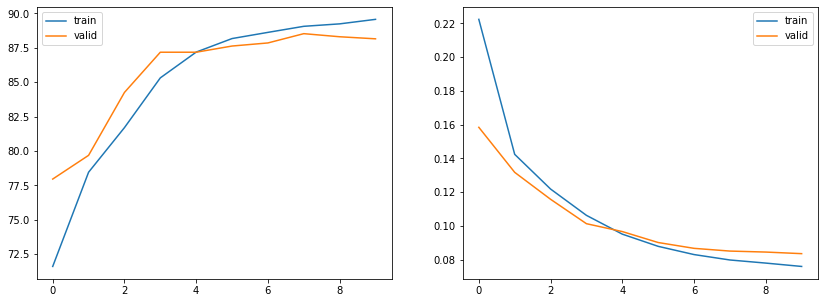

In [206]:
train_acc = [i[0] for i in train_res]
train_loss= [i[1] for i in train_res]
valid_acc = [i[0] for i in valid_res]
valid_loss = [i[1] for i in valid_res]


fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(train_acc, label='train')
ax[0].plot(valid_acc, label='valid')
ax[1].plot(train_loss, label='train')
ax[1].plot(valid_loss, label='valid')
ax[0].legend()
ax[1].legend()